# Evaluation of Clinical Benefit: Week 4 Model

Gaylen Fronk  
July 11, 2024

In [ ]:
study <- "match"
version <- "v6"
y_col_name <- "pp_hybrid_wk4_outcome"


In [ ]:

# packages for script
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: lme4
Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
# absolute paths
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/", y_col_name)
          path_data <- "P:/studydata/match/processed_data"},
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/",
                               y_col_name)
          path_data <- "/Volumes/private/studydata/match/processed_data"},
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/",
                               y_col_name)
          path_data <- "~/mnt/private/studydata/match/processed_data"}
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


Read in aim 2 dataset

In [ ]:
d <- read_csv(file.path(path_models, 
                        str_c("aim_2_", version, "_", y_col_name, ".csv")),
              show_col_types = FALSE) |> 
  mutate(outcome_rct_wk4_num = if_else(outcome_rct_wk4 == "abstinent", 1, 0),
         outcome_rct_wk12_num = if_else(outcome_rct_wk12 == "abstinent", 1, 0),
         outcome_rct_wk26_num = if_else(outcome_rct_wk26 == "abstinent", 1, 0),
         tx_worst = case_when(
           prob_patch < prob_combo_nrt & prob_patch < prob_varenicline ~ "patch",
           prob_combo_nrt < prob_patch & prob_combo_nrt < prob_varenicline ~ "combo_nrt",
           prob_varenicline < prob_patch & prob_varenicline < prob_combo_nrt ~ "varenicline",
           TRUE ~ NA_character_),
         tx_second = case_when(
           tx_worst == "patch" & tx_best == "varenicline" ~ "combo_nrt",
           tx_worst == "patch" & tx_best == "combo_nrt" ~ "varenicline",
           tx_worst == "varenicline" & tx_best == "patch" ~ "combo_nrt",
           tx_worst == "varenicline" & tx_best == "combo_nrt" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "varenicline" ~ "patch",
           tx_worst == "combo_nrt" & tx_best == "patch" ~ "varenicline",
           TRUE ~ NA_character_)) |> 
  mutate(tx_rank = case_when(
    tx_rct == tx_best ~ "first",
    tx_rct == tx_second ~ "second",
    tx_rct == tx_worst ~ "third",
    TRUE ~ NA_character_)) |> 
  select(subid, starts_with("tx_"), starts_with("prob_"),
         outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num) |> 
  pivot_longer(
    cols = c(outcome_rct_wk4_num, outcome_rct_wk12_num, outcome_rct_wk26_num),
    names_to = "week",
    names_pattern = "(?<=outcome_rct_wk)(.+)(?=_num)",
    values_to = "outcome_rct_num"
  ) |> 
  mutate(c_tx_match = if_else(tx_match == TRUE, 0.5, -0.5), # center
         week = as.numeric(week))

glimpse(d)


Rows: 3,258
Columns: 14
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "varenicline", "varenicline", "varenicline", "varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patch", "patc…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_rank          <chr> "second", "second", "second", "second", "second", "se…
$ prob_best        <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ prob_patch       <dbl> 0.2080906, 0.2080906, 0.2080906, 0.4220443, 0.4220443…
$ prob_combo_nrt   <dbl> 0.1754414, 0.1754414, 0.1754414, 0.4957828, 0.4957828…
$ prob_varenicline <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_nu

Read in start-medication data and join

In [ ]:
d_med <- read_csv(file.path(path_data, "match_used_meds_cln.csv"),
                  show_col_types = FALSE)

glimpse(d_med)


Rows: 1,086
Columns: 3
$ subid         <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 20086, …
$ treatment     <chr> "patch", "combo_nrt", "patch", "varenicline", "patch", "…
$ used_any_meds <chr> "started_meds", "started_meds", "no_meds", "started_meds…

Rows: 3,258
Columns: 15
$ subid            <dbl> 20010, 20010, 20010, 20015, 20015, 20015, 20030, 2003…
$ tx_rct           <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_best          <chr> "varenicline", "varenicline", "varenicline", "varenic…
$ tx_match         <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ tx_worst         <chr> "combo_nrt", "combo_nrt", "combo_nrt", "patch", "patc…
$ tx_second        <chr> "patch", "patch", "patch", "combo_nrt", "combo_nrt", …
$ tx_rank          <chr> "second", "second", "second", "second", "second", "se…
$ prob_best        <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ prob_patch       <dbl> 0.2080906, 0.2080906, 0.2080906, 0.4220443, 0.4220443…
$ prob_combo_nrt   <dbl> 0.1754414, 0.1754414, 0.1754414, 0.4957828, 0.4957828…
$ prob_varenicline <dbl> 0.2799119, 0.2799119, 0.2799119, 0.5102584, 0.5102584…
$ week             <dbl> 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26, 4, 12, 26…
$ outcome_rct_nu

## Analyses

In [ ]:
d_wk4 <- d |> 
  filter(week == 4)

d_wk12 <- d |> 
  filter(week == 12)

d_wk26 <- d |> 
  filter(week == 26)


### Primary

4 weeks

In [ ]:
model_4wk <- glm(outcome_rct_num ~ c_tx_match, 
                 data = d_wk4,
                 family = binomial(link = "logit"))

summary(model_4wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_wk4)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.61446    0.06601  -9.308   <2e-16 ***
c_tx_match   0.32376    0.13202   2.452   0.0142 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1388.7  on 1084  degrees of freedom
AIC: 1392.7

Number of Fisher Scoring iterations: 4

12 weeks

In [ ]:
model_12wk <- glm(outcome_rct_num ~ c_tx_match, 
                  data = d_wk12,
                  family = binomial(link = "logit"))

summary(model_12wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_wk12)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.87330    0.06908 -12.642   <2e-16 ***
c_tx_match   0.16522    0.13816   1.196    0.232    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1308.0  on 1085  degrees of freedom
Residual deviance: 1306.6  on 1084  degrees of freedom
AIC: 1310.6

Number of Fisher Scoring iterations: 4

26 weeks

In [ ]:
model_26wk <- glm(outcome_rct_num ~ c_tx_match, 
                  data = d_wk26,
                  family = binomial(link = "logit"))

summary(model_26wk)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_wk26)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.11736    0.07337 -15.229   <2e-16 ***
c_tx_match  -0.01054    0.14674  -0.072    0.943    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1213.6  on 1085  degrees of freedom
Residual deviance: 1213.6  on 1084  degrees of freedom
AIC: 1217.6

Number of Fisher Scoring iterations: 4

### Supplemental analyses: Started medication subset

In [ ]:
d_meds_only <- d |> 
  filter(used_any_meds == "started_meds")

dim(d_meds_only)


[1] 2964   15

4 weeks

In [ ]:
model_4wk_meds <- glm(outcome_rct_num ~ c_tx_match, 
                      data = d_meds_wk4,
                      family = binomial(link = "logit"))

summary(model_4wk_meds)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_meds_wk4)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.48304    0.06788  -7.116 1.11e-12 ***
c_tx_match   0.30643    0.13576   2.257    0.024 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1304.7  on 987  degrees of freedom
Residual deviance: 1299.6  on 986  degrees of freedom
AIC: 1303.6

Number of Fisher Scoring iterations: 4

Still significant, slightly smaller estimate

12 weeks

In [ ]:
model_12wk_meds <- glm(outcome_rct_num ~ c_tx_match, 
                       data = d_meds_wk12,
                       family = binomial(link = "logit"))

summary(model_12wk_meds)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_meds_wk12)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.75888    0.07068 -10.737   <2e-16 ***
c_tx_match   0.14806    0.14136   1.047    0.295    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1230.8  on 987  degrees of freedom
Residual deviance: 1229.7  on 986  degrees of freedom
AIC: 1233.7

Number of Fisher Scoring iterations: 4

Still non-significant

26 weeks

In [ ]:
model_26wk_meds <- glm(outcome_rct_num ~ c_tx_match, 
                       data = d_meds_wk26,
                       family = binomial(link = "logit"))

summary(model_26wk_meds)



Call:
glm(formula = outcome_rct_num ~ c_tx_match, family = binomial(link = "logit"), 
    data = d_meds_wk26)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.00618    0.07465 -13.478   <2e-16 ***
c_tx_match  -0.01841    0.14930  -0.123    0.902    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1149  on 987  degrees of freedom
Residual deviance: 1149  on 986  degrees of freedom
AIC: 1153

Number of Fisher Scoring iterations: 4

Still non-significant

### Supplemental analyses: Treatment rank

In [ ]:
d <- d |> 
  mutate(tx_rank_1v23 = case_match(tx_rank,
                                   "first" ~ 2/3,
                                   c("second", "third") ~ -1/3),
         tx_rank_2v3 = case_match(tx_rank, 
                                  "first" ~ 0,
                                  "third" ~ -.5,
                                  "second" ~ .5))

d_wk4 <- d |> 
  filter(week == 4)

d_wk12 <- d |> 
  filter(week == 12)

d_wk26 <- d |> 
  filter(week == 26)


4 weeks

In [ ]:
model_4wk_rank <- glm(outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, 
                 data = d_wk4,
                 family = binomial(link = "logit"))

summary(model_4wk_rank)



Call:
glm(formula = outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, family = binomial(link = "logit"), 
    data = d_wk4)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.66820    0.06450 -10.360   <2e-16 ***
tx_rank_1v23  0.32342    0.13203   2.450   0.0143 *  
tx_rank_2v3   0.03144    0.16334   0.192   0.8474    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1394.7  on 1085  degrees of freedom
Residual deviance: 1388.6  on 1083  degrees of freedom
AIC: 1394.6

Number of Fisher Scoring iterations: 4

12 weeks

In [ ]:
model_12wk_rank <- glm(outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, 
                  data = d_wk12,
                  family = binomial(link = "logit"))

summary(model_12wk_rank)



Call:
glm(formula = outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, family = binomial(link = "logit"), 
    data = d_wk12)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.90187    0.06723 -13.415   <2e-16 ***
tx_rank_1v23  0.16678    0.13822   1.207    0.228    
tx_rank_2v3  -0.09021    0.16959  -0.532    0.595    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1308.0  on 1085  degrees of freedom
Residual deviance: 1306.3  on 1083  degrees of freedom
AIC: 1312.3

Number of Fisher Scoring iterations: 4

26 weeks

In [ ]:
model_26wk_rank <- glm(outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, 
                  data = d_wk12,
                  family = binomial(link = "logit"))

summary(model_26wk_rank)



Call:
glm(formula = outcome_rct_num ~ tx_rank_1v23 + tx_rank_2v3, family = binomial(link = "logit"), 
    data = d_wk12)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.90187    0.06723 -13.415   <2e-16 ***
tx_rank_1v23  0.16678    0.13822   1.207    0.228    
tx_rank_2v3  -0.09021    0.16959  -0.532    0.595    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1308.0  on 1085  degrees of freedom
Residual deviance: 1306.3  on 1083  degrees of freedom
AIC: 1312.3

Number of Fisher Scoring iterations: 4

## Figures

Primary figure

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

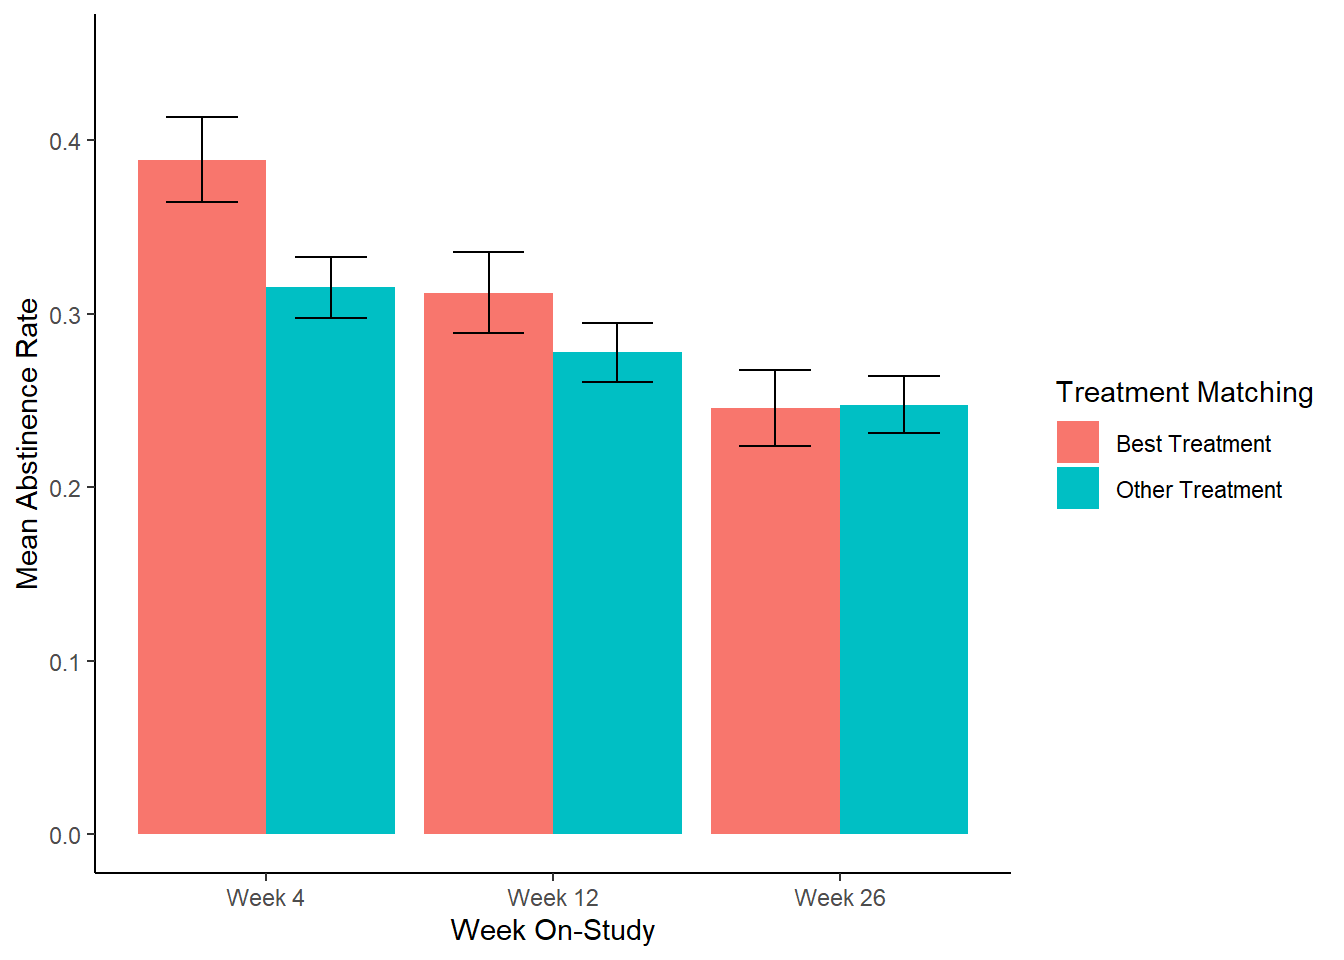

In [ ]:

fig_clin_ben_wk4 <- d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = week_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.45)) +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


Primary figure (replicated for supplement)

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

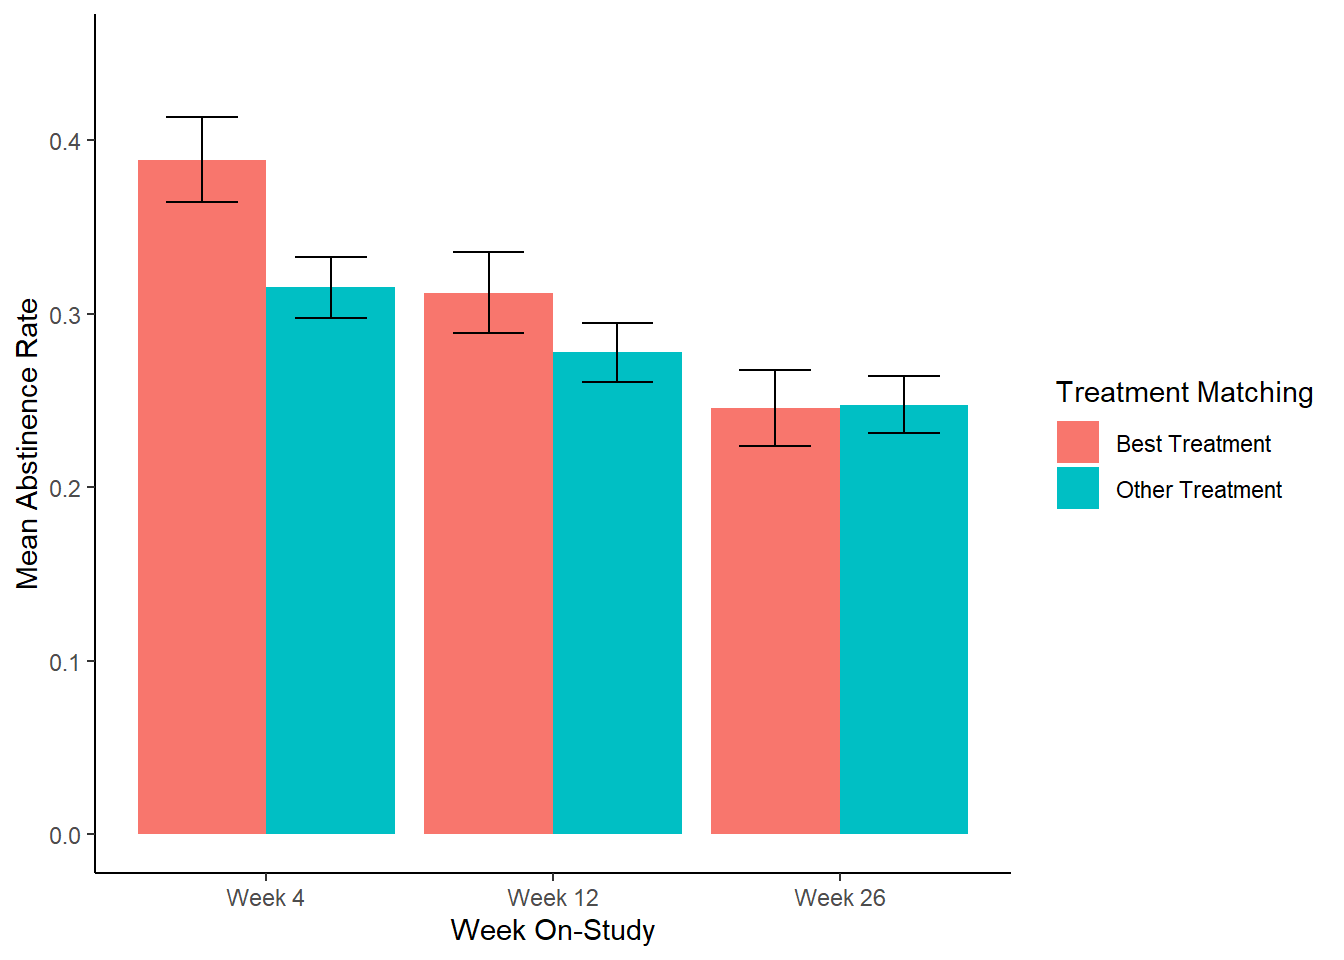

In [ ]:

fig_clin_ben_wk4_supp <- d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = week_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.45)) +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


Supplemental figure: Started medication subset

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

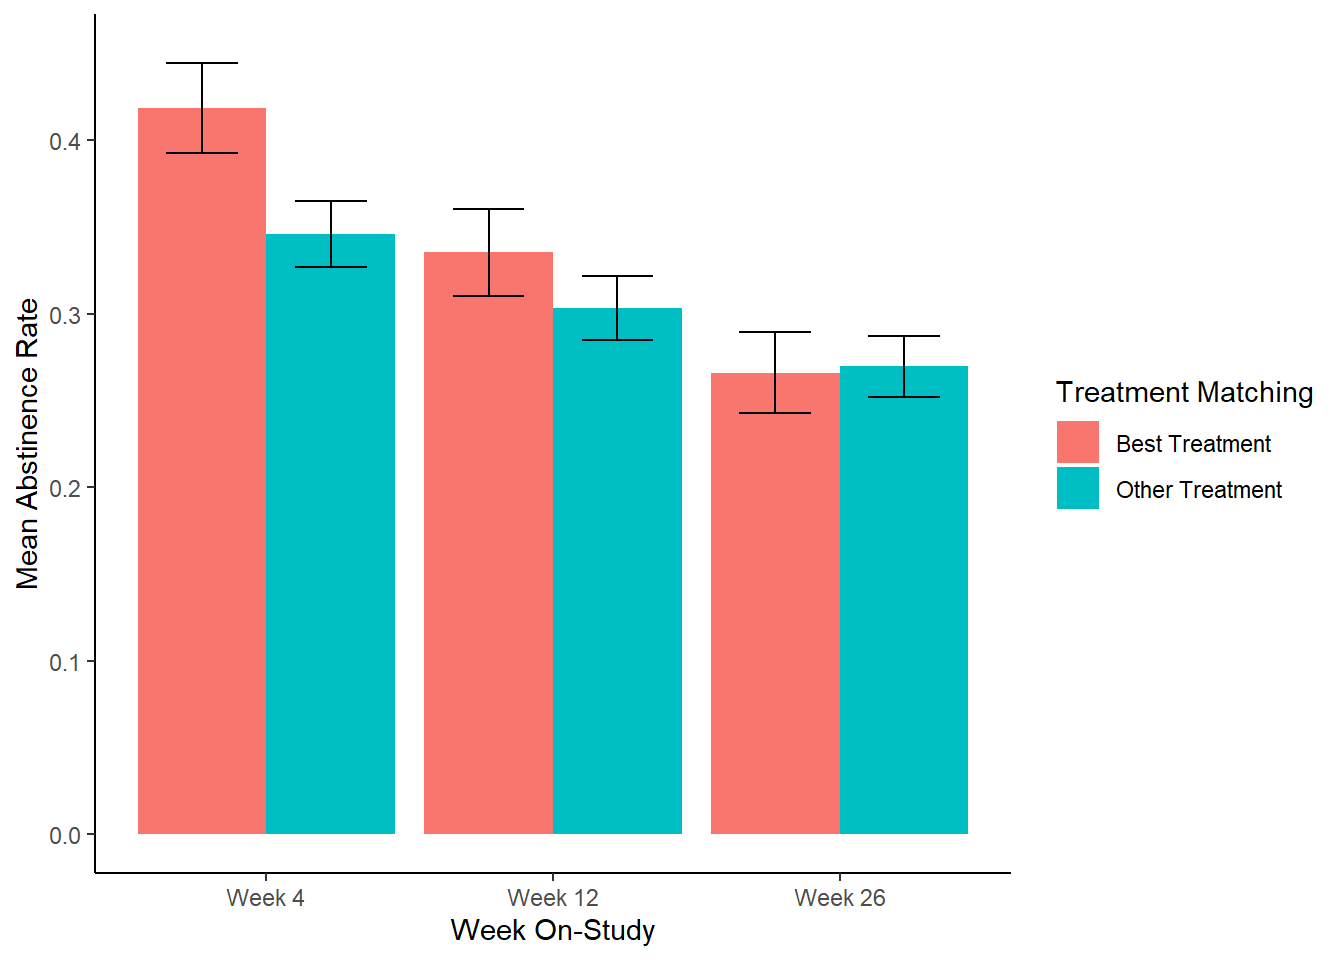

In [ ]:

fig_med_subset_wk4_supp <- d_meds_only |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Best Treatment", "Other Treatment"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = week_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.45)) +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )


Supplemental figure: Treatment rank

`summarise()` has grouped output by 'week_cat'. You can override using the
`.groups` argument.

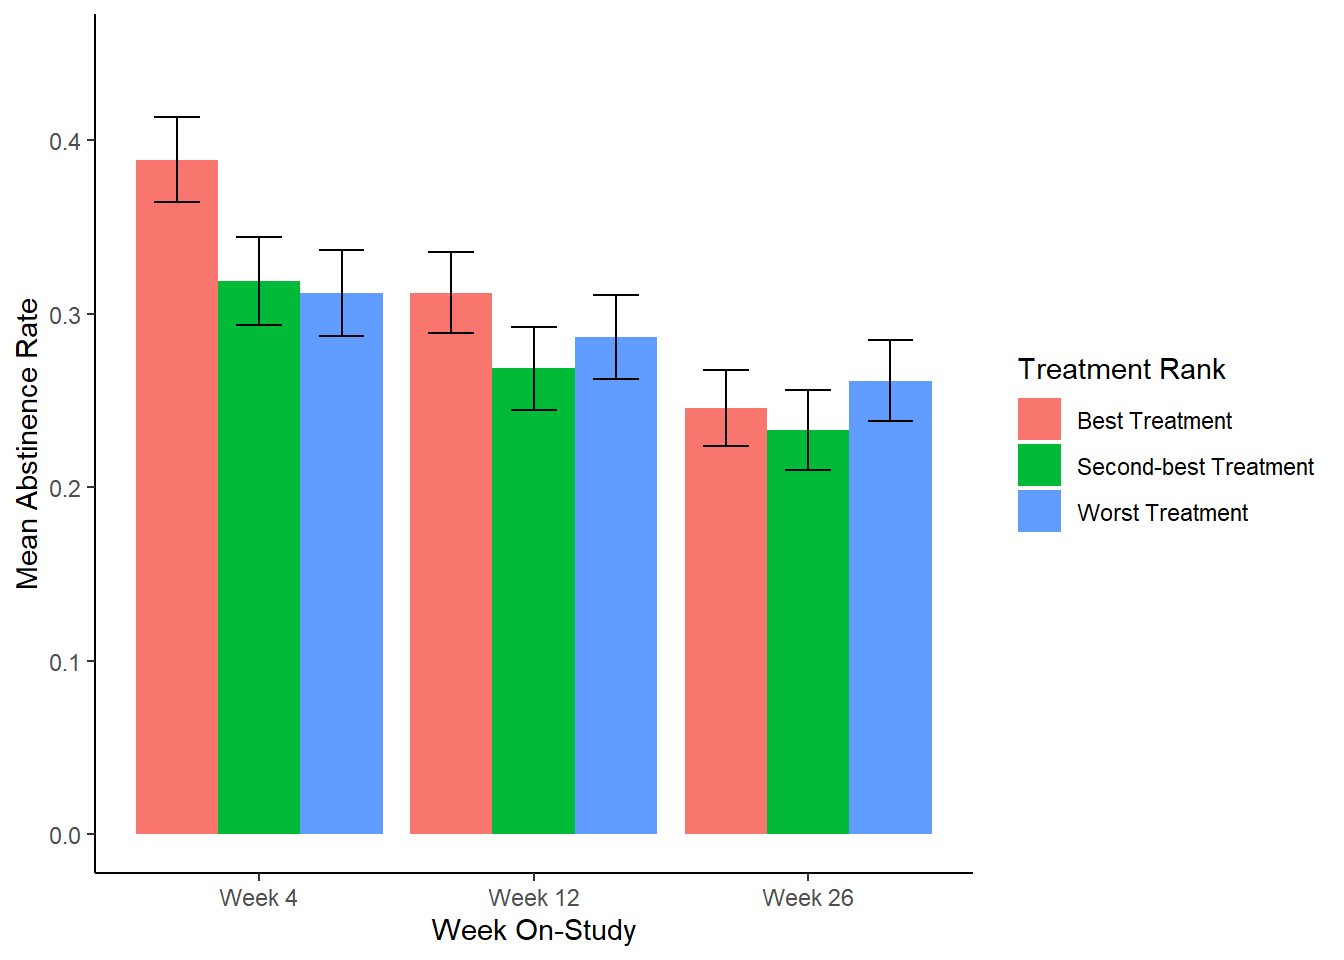

In [ ]:

fig_rank_wk4_supp <- d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_rank = factor(tx_rank, 
                           levels = c("first", "second", "third"),
                           labels = c("Best Treatment", "Second-best Treatment",
                                      "Worst Treatment"))) |> 
  group_by(week_cat, tx_rank) |> 
  summarize(mean_outcome = mean(outcome_rct_num),
            sd_outcome = sd(outcome_rct_num),
            n_group = n()) |> 
  mutate(se_outcome = (sd_outcome / sqrt(n_group))) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_rank)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = mean_outcome - se_outcome, 
                    ymax = mean_outcome + se_outcome,
                    x = week_cat),
                position = position_dodge(width = 0.9),
                width = 0.5) +
  scale_y_continuous(limits = c(0, 0.45)) +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Rank"
  )
